## Overview
In this class, the two major themes have been ordinary and partial differential equations. We have also considered underlying numerical methods having to do with differentiation and integration as well as Python programming. As a final assessment of what you have learned in class, I'd like you to merge what you know about ordinary and partial differential equations. This is done elegantly using a technique called *the numerical method of lines*. The idea of this method follows.

Partial differential equations can be written as:

$\frac{\partial \mathbf{u}}{\partial t} = \mathcal{D} \cdot \mathbf{u} + s$

where $\mathbf{u}$ is a vector of unknowns, $\mathcal{D}$ is a differential operator in space, and $s$ a source/sink term. Along with boundary conditions, this forms a complete problem. $\mathcal{D}$ may be a new idea to you; it would just be $\nabla^2$ in our experience, but could be any order of derivative, or a sum of derivatives, or products of derivatives and other variables. It's just a way of generalizing the problem.

In the past we have treated equations like this by using forward Euler on the time derivative and a centered scheme for the space derivative. We've also implemented implicit and Crank-Nicolson methods. 

In a way, the method of lines is easier. Begin by ignoring the time derivative. Find a finite difference (or even finite element) approximation of $\mathcal{D}$, the differential operator. Write code that applies it to $\mathbf{u}$. Then, instead of discretizing $\frac{\partial \mathbf{u}}{\partial t}$, treat the system of equations as an ordinary differential equation. In this case, your $\mathcal{D} \cdot \mathbf{u}+s$ will have to be returned by the function that is passed to the ODE solving machinery.

### Problem statement

Solve the heat equation

$\frac{dT}{dt} = k \nabla^2 T + \frac{s}{\rho c_p}$

for a circular electric kettle of radius 5 cm. The kettle has a steel plate on the bottom and a ring heating element under the steel. The heating ring under the steel is active from $r = $2 to $r = $4 cm. The ring produces a total energy of 1200 Watts. The steel plate is 2 mm thick.

Everything outside the kettle is at room temperature, or 23.5 degrees C. This temperature forms the boundary condition for the problem.

Determine how long it takes for the center of the steel plate to reach 125 degrees C. Report that time, and produce 4 equally spaced (in time) plots of the temperature of the kettle plate. They should start at time zero, and end when the plate reaches the desired temperature in the middle.

Take into account realistic physical properties for the plate and the heating element.

### Time derivative

As mentioned, we're going to use a higher order time integration routine, instead of forward Euler on $\frac{\partial \mathbf{u}}{\partial t}$. To remind you, I've pasted the Runge Kutta 4th order method below. You'll be calling this function later. Feel free to replace mine with your if you are more comfortable with your syntax.

In [2]:
import numpy as np
import pylab as pl
from __future__ import division

def rk4(f, x, t, dt):
    k1 = f(x,t)
    k2 = f(x + dt / 2 * k1, t + dt / 2)
    k3 = f(x + dt / 2 * k2, t + dt / 2)    
    k4 = f(x + dt * k3    , t + dt)    
    return x + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

### Space derivative and desretization
In the following lines of code, let us create a space derivative for the $k\nabla^2$ operator. Don't forget the $\Delta x^2$ in the denominator. Let's also set up the descretization of the problem - the domain size, the degrees of freedom, the grid, and the time step. 

*To recieve full credit, you must use a sparse matrix for this portion!*

In [3]:
from scipy.sparse import csr_matrix,lil_matrix

# The discretization of the problem (use these to avoid trouble with instability)
N  =  25    # Space domain will be N x N
dt = .10    # Time step in seconds
L  = .11    # Radius of simulated area, large enough to place a 5 cm radius round kettle inside. # NOTE CHANGED TO .11

x,y   =  np.linspace(-L/2, L/2, N), np.linspace(-L/2, L/2, N) # locations of x and y points
xg,yg =  np.meshgrid(x, y) # grids for x and y

dx =    L/N # grid spacing

# The differential operator
A = np.diag([-4] * N**2) # diagonols, local element
A += np.diag([1] * (N**2 - 1), 1) + np.diag([1] * (N**2 - 1), -1) # left and right
A += np.diag([1] * (N**2 - N), N) + np.diag([1] * (N**2 - N), -N) # top and bottom
A = np.divide(A, dx**2) # handle the delta x term in the denomenator

A = csr_matrix(A) # sparse matrix

### Initial conditions and physics

Now, create a set of functions to describe the kettle geometry, heat source, intial conditions, and the function that is called by **rk4**.


In [13]:
# Physical features:
k          = 1.172e-5     # thermal diffusivity in m**2/s for 1% carbon steel
cp         = .446e3       # Heat capacity of steel in J/(K kg)
rho        = 8050         # Density of steel in kg/m**2
room_temp  = 23.5         # room temperature
final_temp = 125          # desired temperature at the center of the plate
thickness  = .002         # thickness of steel plate # NOTE CHANGED TO 2 AS PER EMAIL NOTE
power      = 1200         # Power of kettle, in Watts

r_out = 0.04
r_in = 0.02

def outside(xg,yg,rout=.04):
    # This functions accepts the x and y grids
    # it returns indices of grid points that lie OUTSIDE
    # the radius specified, rout.
    # The idea is that this function is called and returns the indices
    # that are later set to be room temperature. HINT: use pl.find
    rg = np.sqrt(xg**2 + yg**2) # calculate radius at all points
    ids = pl.find((rg > rout)) # find id's of points with radius > rout
    return ids

def source(x,y,heat,rmin=.02,rmax=.04):
    # Function to produce the heat source - 
    # does a pair of logical tests on r, the radius of the kettle, 
    # starting from 0 at the center.
    # Returns a matrix of zeros except where r is between
    # rmin and rmax. There it returns heat.
    # HINT: Turn a logical array to a float one with array.astype(float)
    rg = np.sqrt(xg**2 + yg**2) # calculate radius at all points
    s = ((rg <= rmax) & (rg >=rmin)) # find id's of points between rmin an drmax
    heats = s.astype(float) * heat # make heat instead of bools
    return heats


# initial temperature (room temperature), known on a N**2 x 1 vector
u0 = np.full(N**2, room_temp)

# Heat source, careful with dimensions here:

# Heat from hot plate: should be watts generated divided by 
# area of element times thickness of steel plate
# divided by rho times cp
area = ((r_out ** 2) - (r_in**2)) * np.pi
heat   = power / (area * thickness) / (rho * cp)

# Determine which nodes are outside the kettle
OUTSIDE = outside(xg, yg)
SOURCE = source(xg, yg, heat).flatten()

# This is the function that is passed to rk4, it finds the new rates of change of
# temperature, as per the partial differential equation.
# Setting the values outside the kettle to zero in this function will prevent
# them from changing from thier initial values.
def heat_eqn(u,t): # f(x, t) in rk4
    # what do i do with t? ignore it?
    return (k * A.dot(u)) + SOURCE

### Running the simulation

Preform the integration forward in time, using **rk4**, until the center of the kettle reaches the final temperature. Store outputs for eventual plotting.

In [14]:
un = []
u = u0
temp = room_temp
t = 0
while (temp < final_temp):
    u = rk4(heat_eqn, u, t, dt)
    u[OUTSIDE] = room_temp
    temp = u[int(N**2 / 2)]
    un.append(u)
    t += dt
print("Time to temp: " + str(t))


Time to temp: 11.199999999999976


### Analysis and plotting

Now plot the results. Observe that I've introduced a deliberate error in my code so that you don't know the correct answer. However, the following shows you how to display results.

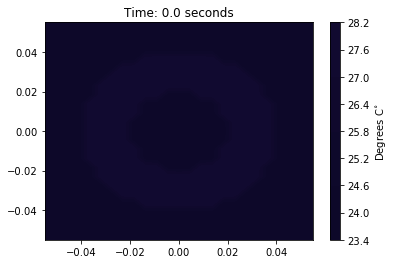

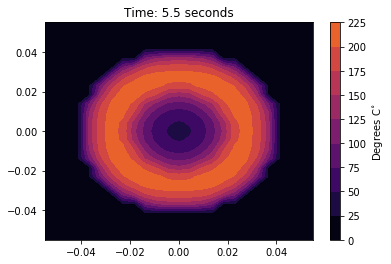

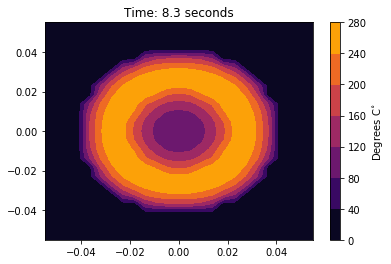

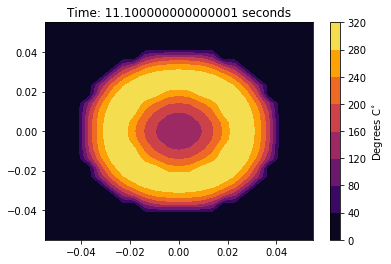

In [12]:
import pylab as pl

size = len(un) - 1
pv = [0, int(2 * size / 4), int(3 * size /4),  size]  # The values that get plotted, based on problem statement.
zmin, zmax = 0, np.max(un[size]) + 10
for ti in pv:
    pl.contourf(xg,yg,un[ti].reshape(N,N),cmap='inferno',vmin=zmin, vmax=zmax)
    # note that i explicitly set the min/max of the vscale
    # I feel this is important to make the four plots comperable to eachother
    # without doing this, each plot consumes the entire colour scale for its range
    # to make my plots look like the ones provided, simply remove the vmin and vmax arguments from the contourf call
    cb = pl.colorbar()
    cb.set_label(r"Degrees C$^{\circ}$")
    pl.title("Time: %s seconds"%(ti*dt))
    pl.show()